In [17]:
import numpy as np
import scipy
from scipy import ndimage
from scipy import signal
import scipy.io as sio
import scipy.io.wavfile
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from scipy.ndimage import interpolation
import cv2

In [18]:
def make_histogram(image):
    hist = np.zeros(256, dtype=int)
    for i in range(image.size):
        hist[image[i]] += 1
    return hist

def total(hist):
    total_sum = np.zeros(256, dtype=int)
    total_sum[0] = hist[0]
    for i in range(1, hist.size):
        total_sum[i] = total_sum[i-1] + hist[i]
    return total_sum

def histogram_map(image, total_sum):
    mapping = np.zeros(256, dtype=int)
    for i in range(256):
        mapping[i] = max(0, round((total_sum[i])/256-1))
    new_image = np.zeros(image.size, dtype=int)
    for i in range(image.size):
        new_image[i] = mapping[image[i]]
    return new_image

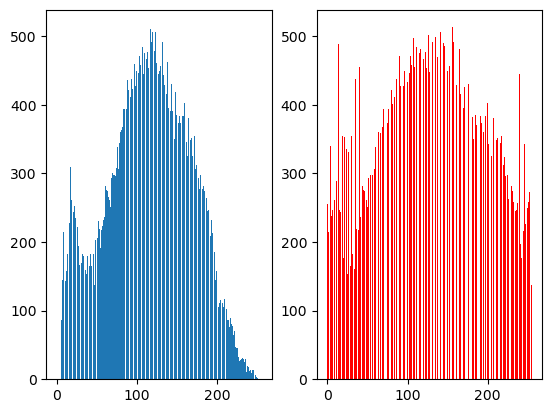

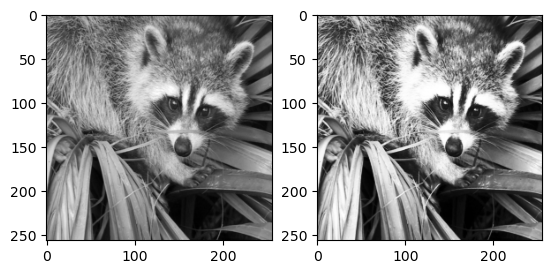

In [24]:
file = "X.png"
out_file = "X_historgam.png"
image = Image.open(file)
original = image
w, h = image.size

image = np.array(image).flatten()
histogram = make_histogram(image)
total_sum = total(histogram)
img_histeq = histogram_map(image, total_sum)

output_image = Image.fromarray(np.uint8(img_histeq.reshape((w, h))))
output_image.save(out_file)

x_axis = np.arange(256)
fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.bar(x_axis, histogram)
fig.add_subplot(1, 2, 2)
plt.bar(x_axis, make_histogram(img_histeq), color="red")
plt.show()
fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(original, cmap='gray')
fig.add_subplot(1, 2, 2)
plt.imshow(output_image, cmap='gray')
plt.show()

In [20]:
mask_1 = 1./5 * np.array([[0, 1, 0],[1, 1, 1],[0, 1, 0]])

mask_2 = 1./9 * np.array([[1, 1, 1],[1, 1, 1],[1, 1, 1]])

mask_3 = 1./13 * np.array([[0, 0, 1, 0, 0],[0, 1, 1, 1, 0],[1, 1, 1, 1, 1],[0, 1, 1, 1, 0],[0, 0, 1, 0, 0]])

mask_4 = 1./21 * np.array([[0, 1, 1, 1, 0],[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],[0, 1, 1, 1, 0]])

mask_5 = 1./25 * np.array([[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],[1, 1, 1, 1, 1]])

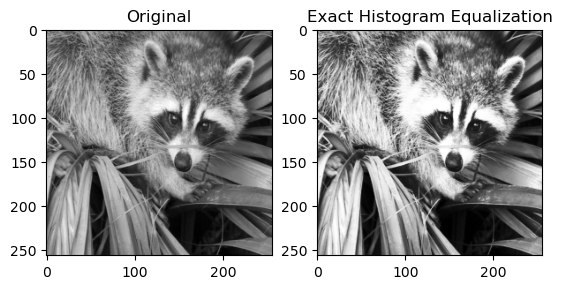

In [21]:
def exact_hist(image): 
    image = np.asarray(image.convert('L'))
    flattened = image.flatten()
    width, height = image.shape

    image1 = np.array(image).flatten()
    masks = [mask_1, mask_2, mask_3, mask_4, mask_5]

    conv_masks = np.array([signal.convolve2d(image, mask, 'same') for mask in masks])
    
    conv_masks = [mask.flatten() for mask in conv_masks]
    sorted_pixels = np.lexsort((conv_masks[0], conv_masks[1], conv_masks[2], conv_masks[3], conv_masks[4], image1))

    groups = np.split(sorted_pixels, 256)
    
    for i in range(len(groups)): 
        group = groups[i]
        for j in range(len(group)):
            flattened[group[j]] = i
    
    return flattened.reshape((256, 256))

image = Image.open(file)

fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original')
fig.add_subplot(1, 2, 2)
plt.imshow(exact_hist(image), cmap='gray')
plt.title('Exact Histogram Equalization')
plt.show()

In [3]:
def Rotate2D(image, angle):
    width, height = image.shape
    theta = np.radians(-1*angle)
    cos, sin = np.cos(theta), np.sin(theta)
    rotate = np.zeros((width, height), dtype=int)
    
    to_center = np.array([[1, 0, width/2], [0, 1, height/2], [0, 0, 1]])
    from_center = np.array([[1, 0, -width/2], [0, 1, -height/2], [0, 0, 1]])
    matrix = np.array([[cos, -sin, 0], [sin, cos, 0], [0, 0, 1]])
    rotate_matrix = np.dot(np.dot(to_center, matrix), from_center)

    
    for i in range(width):
        for j in range(height):
            pixel = np.dot(rotate_matrix, [i, j, 1])
            if -1 < pixel[0] < width and -1 < pixel[1] < height: 
                rotate[i][j] = image[int(pixel[0])][int(pixel[1])] 
    return rotate

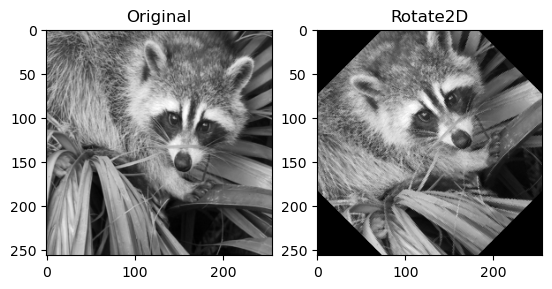

In [56]:
image = Image.open('X.png')
x = np.asarray(image.convert('L'))

fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original')
fig.add_subplot(1, 2, 2)
plt.imshow(Rotate2D(x, 45), cmap='gray')
plt.title('Rotate2D')
plt.savefig('Rotated_X.png')
plt.show()

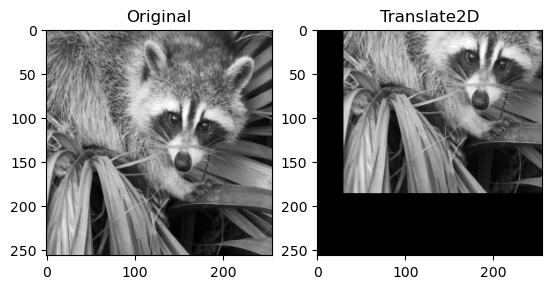

In [57]:
def Translate2D(image, translation):
    width, height = image.shape
    c, r = translation
    translate = np.zeros((width, height), dtype=int)
    translate_matrix = np.array([[1, 0, -r], [0, 1, -c]])
    
    for i in range(width):
        for j in range(height):
            pixel = np.dot(translate_matrix, [i, j, 1])
            if -1 < pixel[0] < width and -1 < pixel[1] < height: 
                translate[i][j] = image[int(pixel[0])][int(pixel[1])] 

    return translate

fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original')
fig.add_subplot(1, 2, 2)
plt.imshow(Translate2D(x, [30, -70]), cmap='gray')
plt.title('Translate2D')
plt.savefig('Translate_X.png')
plt.show()

In [41]:
def MyFFT2D(image):
    row, col = image.shape
    padded_row = int(pow(2, np.ceil(np.log2(row))))
    padded_col = int(pow(2, np.ceil(np.log2(col))))
    padded_image = np.zeros((padded_row, padded_col))
    padded_image[:row, :col] = image

    fft_image = np.zeros(padded_image.shape, dtype=np.complex64)
    for i in range(padded_row):
        fft_image[i, :] = np.fft.fft(padded_image[i, :].flatten())
        
    for j in range(padded_col):
        fft_image[:, j] = np.fft.fft(fft_image[:, j].flatten())

    return fft_image

In [42]:
def CenterFFT2D(fft_image):
    row, col = fft_image.shape
    fft_image = np.fft.fftshift(fft_image)

    return fft_image

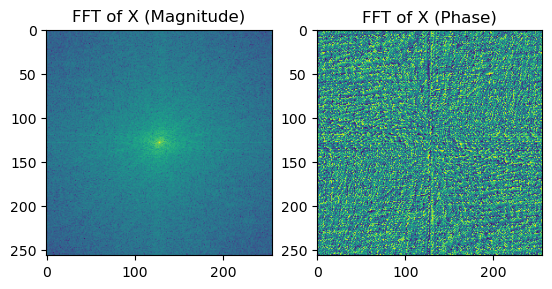

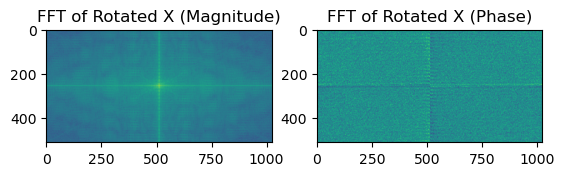

In [55]:
X = cv2.imread('X.png', cv2.IMREAD_GRAYSCALE)
Rotated_X = cv2.imread('Rotated_X.png', cv2.IMREAD_GRAYSCALE)

X_fft = MyFFT2D(X)
X_fft = CenterFFT2D(X_fft)

RotatedX_fft = MyFFT2D(Rotated_X)
RotatedX_fft = CenterFFT2D(RotatedX_fft)

X_fft_mag = np.log(np.abs(X_fft))
X_fft_phase = np.angle(X_fft)
RotatedX_fft_mag = np.log(np.abs(RotatedX_fft))
RotatedX_fft_phase = np.angle(RotatedX_fft)

fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(X_fft_mag)
plt.title('FFT of X (Magnitude)')
fig.add_subplot(1, 2, 2)
plt.imshow(X_fft_phase)
plt.title('FFT of X (Phase)')
plt.show()

fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(RotatedX_fft_mag)
plt.title('FFT of Rotated X (Magnitude)')
fig.add_subplot(1, 2, 2)
plt.imshow(RotatedX_fft_phase)
plt.title('FFT of Rotated X (Phase)')
plt.show()

/var/folders/4f/1_jvn11d6vj34rz48dp_5cyr0000gn/T/ipykernel_21871/407160430.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  padded_image[:row, :col] = image


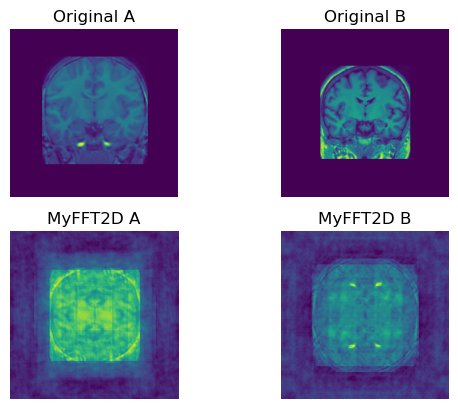

In [53]:
a = cv2.imread('a.png', cv2.IMREAD_GRAYSCALE)
b = cv2.imread('b.png', cv2.IMREAD_GRAYSCALE)

A = MyFFT2D(a)
B = MyFFT2D(b)

A_phase = np.angle(A)
B_phase = np.angle(B)
A_swap_phase = B_phase
B_swap_phase = A_phase

A_swapped = np.abs(A) * np.exp(1j * A_swap_phase)
B_swapped = np.abs(B) * np.exp(1j * B_swap_phase)

A_inverse = MyFFT2D(A_swapped)
B_inverse = MyFFT2D(B_swapped)

rows = 2
columns = 2
image_a = Image.open('a.png')
image_b = Image.open('b.png')
fig = plt.figure()
fig.add_subplot(rows, columns, 1)
plt.imshow(image_a)
plt.axis('off')
plt.title('Original A')
fig.add_subplot(rows, columns, 2)
plt.imshow(image_b)
plt.axis('off')
plt.title('Original B')
fig.add_subplot(rows, columns, 3)
plt.imshow(np.abs(A_inverse))
plt.axis('off')
plt.title('MyFFT2D A')
fig.add_subplot(rows, columns, 4)
plt.imshow(np.abs(B_inverse))
plt.axis('off')
plt.title('MyFFT2D B')
plt.show()